# Define configurations

In [1]:
user = 'participant1'
frequency = '15min' # 15min | 15s
dataset_type = '' # ''

if frequency == '15min':
    record_size_per_day = 96
elif frequency == '15s':
    record_size_per_day = 5760

# Columns to include    
if dataset_type == '':
    columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
            'time_from_last_drug_taken', 'wearing_off' ]

metrics = {
    'balanced_accuracy': 'Bal. Acc.',
    'f1_score': 'F1 Score',
    'accuracy': 'Acc.',
    'precision': 'Precision',
    'sensitivity': 'Recall / Sn',
    'specificity': 'Sp',
    'auc': 'AUC'
}

# Preparation

## Load libraries

In [2]:
from datetime import datetime
from datetime import timedelta
from typing import Union, Generator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

import sklearn
from photonai.base import Hyperpipe, PipelineElement, Stack, Switch
from photonai.optimization import FloatRange, IntegerRange, Categorical, BooleanSwitch, PhotonHyperparam
from photonai.optimization import Categorical as PhotonCategorical
from photonai.optimization import MinimumPerformanceConstraint, DummyPerformanceConstraint, BestPerformanceConstraint
from photonai.optimization.base_optimizer import PhotonSlaveOptimizer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

from skopt import Optimizer
from skopt.space import Real, Integer, Dimension
from skopt.space import Categorical as skoptCategorical
from photonai.photonlogger.logger import logger
from photonai.optimization.scikit_optimize.sk_opt import SkOptOptimizer

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=Warning)
from photonai.base import Hyperpipe
from photonai.optimization import MinimumPerformanceConstraint
from photonai.photonlogger import logger 

## Load combined data

In [3]:
combined_data = pd.read_excel(f'./data/combined_data/{dataset_type}combined_data_{user}_{frequency}.xlsx',
                              index_col="timestamp",
                              usecols=columns,
                              engine='openpyxl')
if dataset_type == '':
    y = combined_data.loc[:, combined_data.columns == 'wearing_off'].values[:,0]
    X = combined_data.loc[:, columns[1:-1]]

## Define Functions

In [4]:
# Show feature importances
def print_feature_importances(pipeline):
    output = ''
    if pipeline.optimum_pipe.feature_importances_ is None:
        output = 'Best Hyperparameter Configuration is a non-linear SVM, thus feature importances cannot be retrieved'
    else:
        output = 'Feature Importances using the Best Hyperparameter Config'
        if not [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE']:
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
        else:
            mask = [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE'][0]
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])[mask]
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
    return output

In [5]:
def plot_cv_indices(cv, X, y, ax, n_splits=0, lw=20):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                    c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                    vmin=-.2, vmax=1.2)

    n_splits = ii + 1

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['wearing-off']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Records\'s Index', ylabel="Folds",
           ylim=[n_splits+1.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


In [6]:
def plot_confusion_matrix_from_pipeline(pipeline):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(
        pipeline.results_handler.get_test_predictions()['y_true'],
        pipeline.results_handler.get_test_predictions()['y_pred'],
        labels=[0,1], normalize=None)
    ax = plt.subplot()
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'25'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    # title_font = {'size':'21'}  # Adjust to fit
    # ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=25)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Good', 'Wearing-Off']);
    ax.yaxis.set_ticklabels(['Good', 'Wearing-Off']);
    plt.rc('text') # , usetex=False)
    plt.rc('font', family='serif')
    # plt.savefig('./participant2-downsampling-confusionmatrix-real.pdf', bbox_inches='tight')
    plt.show()

In [7]:
# Write other reports to summary file
def add_other_report_to_summary(pipeline, with_estimator_comparison=True):
    with open(f'{pipeline.output_settings.results_folder}/photon_summary.txt', "a+") as summary_file:
        # 1. Write comparison of learning algorithms
        if with_estimator_comparison:
            summary_file.write("\n\n")
            summary_file.write("Comparison on learning algorithms on validation set")
            summary_file.write("\n")
            summary_file.write(str(pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator()))

        # 2. Write feature importance
        summary_file.write("\n\n")
        summary_file.write("Feature Importance")
        summary_file.write(print_feature_importances(pipeline))
        
        # 3. Write beautified average test performance across outer folds
        # a. Get Average Test Performance Across Outer Folds
        test_metric_result = pipeline.results.get_test_metric_dict()
        
        # b. Replace display metric name
        #   Reference: https://stackoverflow.com/a/55250496/2303766
        test_metric_result = { metrics[metric]: test_metric_result[metric]
                                  for metric, metric_name in metrics.items() if metric in test_metric_result
                             }
        
        # c. Add beautified average test performance across outer folds to file 
        summary_file.write("\n\n")
        summary_file.write("Average Test Performance Across Outer Folds")
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(
                    test_metric_result
                ).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )
        
        # 4. Write outer fold results
        summary_file.write("\n\n")
        summary_file.write("Outer Fold Best Estimators' Performance")
        summary_file.write("\n")
        handler = pipeline.results_handler
        performance_table = handler.get_performance_table()
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold', 'best_config', 'n_train', 'n_validation']].transpose(),
                    tablefmt='psql', headers='keys'
                )
            )
            summary_file.write("\n")
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold'] + list(metrics.keys())].round(4).transpose(),
                    tablefmt='psql', floatfmt=".4f", headers='keys'
                )
            )
            
        outer_fold_performance = {}
        config_evals = handler.get_config_evaluations()
        for metric in metrics.keys():
            # print(f'{metric}')
            for i, j in enumerate(config_evals[metric]):
                if f'{metric}_mean' in outer_fold_performance:
                    # outer_fold_performance[f'{metric}_max'].append(np.max(j))
                    outer_fold_performance[f'{metric}_mean'].append(np.mean(j))
                    outer_fold_performance[f'{metric}_std'].append(np.std(j))
                else:
                    # outer_fold_performance[f'{metric}_max'] = [np.max(j)]
                    outer_fold_performance[f'{metric}_mean'] = [np.mean(j)]
                    outer_fold_performance[f'{metric}_std'] = [np.std(j)]
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(outer_fold_performance).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )

In [8]:
# PhotonAI Optimize Monkey-patch
#     Added random_state for Optimize for result replicability
def prepare(self, pipeline_elements: list, maximize_metric: bool) -> None:
    """
    Initializes hyperparameter search with scikit-optimize.

    Assembles all hyperparameters of the list of PipelineElements
    in order to prepare the hyperparameter space.
    Hyperparameters can be accessed via pipe_element.hyperparameters.

    Parameters:
        pipeline_elements:
            List of all PipelineElements to create the hyperparameter space.

        maximize_metric:
            Boolean to distinguish between score and error.

    """
    self.start_time = None
    self.optimizer = None
    self.hyperparameter_list = []
    self.maximize_metric = maximize_metric

    # build skopt space
    space = []
    for pipe_element in pipeline_elements:
        if pipe_element.__class__.__name__ == 'Switch':
            error_msg = 'Scikit-Optimize cannot operate in the specified hyperparameter space with a Switch ' \
                        'element. We recommend the use of SMAC.'
            logger.error(error_msg)
            raise ValueError(error_msg)

        if hasattr(pipe_element, 'hyperparameters'):
            for name, value in pipe_element.hyperparameters.items():
                # if we only have one value we do not need to optimize
                if isinstance(value, list) and len(value) < 2:
                    self.constant_dictionary[name] = value[0]
                    continue
                if isinstance(value, PhotonCategorical) and len(value.values) < 2:
                    self.constant_dictionary[name] = value.values[0]
                    continue
                skopt_param = self._convert_photonai_to_skopt_space(value, name)
                if skopt_param is not None:
                    space.append(skopt_param)

    if self.constant_dictionary:
        msg = "PHOTONAI has detected some one-valued params in your hyperparameters. Pleas use the kwargs for " \
              "constant values. This run ignores following settings: " + str(self.constant_dictionary.keys())
        logger.warning(msg)
        warnings.warn(msg)

    if len(space) == 0:
        msg = "Did not find any hyperparameter to convert into skopt space."
        logger.warning(msg)
        warnings.warn(msg)
    else:
        self.optimizer = Optimizer(space,
                                   base_estimator=self.base_estimator,
                                   n_initial_points=self.n_initial_points,
                                   initial_point_generator=self.initial_point_generator,
                                   acq_func=self.acq_func,
                                   acq_func_kwargs=self.acq_func_kwargs,
                                   random_state=4
                                  )
    self.ask = self.ask_generator()
    
#    Monkey patched new prepare function
SkOptOptimizer.prepare = prepare

## Visualize Data Split

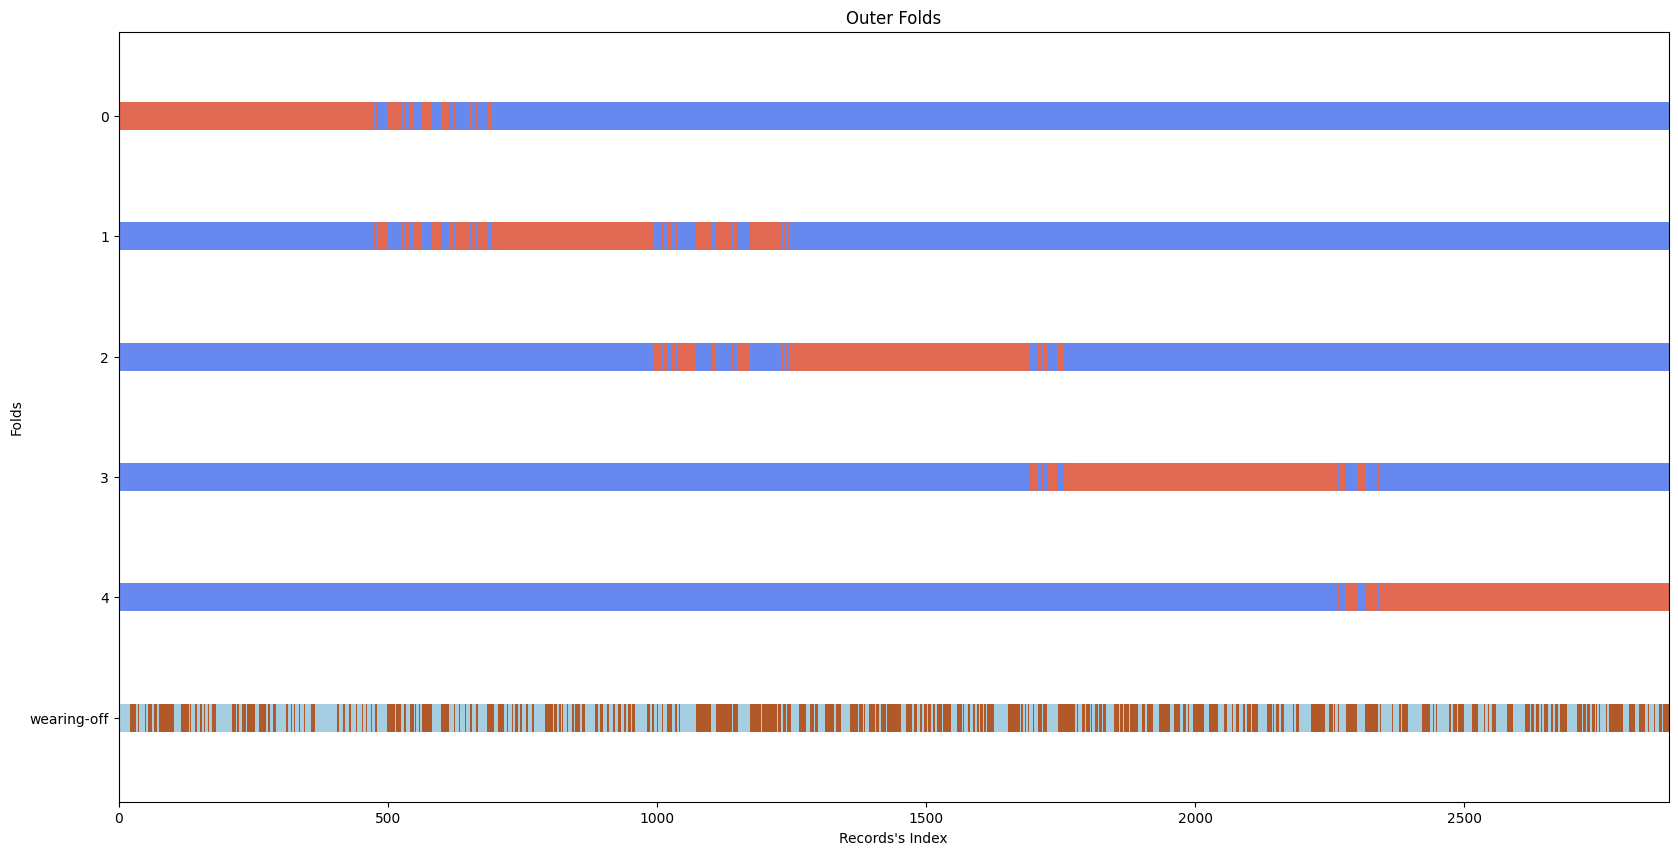

Train Set for Outer Fold 0
[ 482  483  488 ... 2877 2878 2879]

Train Set for Outer Fold 1
[   0    1    2 ... 2877 2878 2879]

Train Set for Outer Fold 2
[   0    1    2 ... 2877 2878 2879]

Train Set for Outer Fold 3
[   0    1    2 ... 2877 2878 2879]

Train Set for Outer Fold 4
[   0    1    2 ... 2323 2347 2348]



In [9]:
# Outer CV
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=5, shuffle=False)
plot_cv_indices(cv, X, y, ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title('Outer Folds')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

training_folds = []
for train, test in cv.split(X, y):
    print(f'Train Set for Outer Fold {len(training_folds)}')
    print(train)
    training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

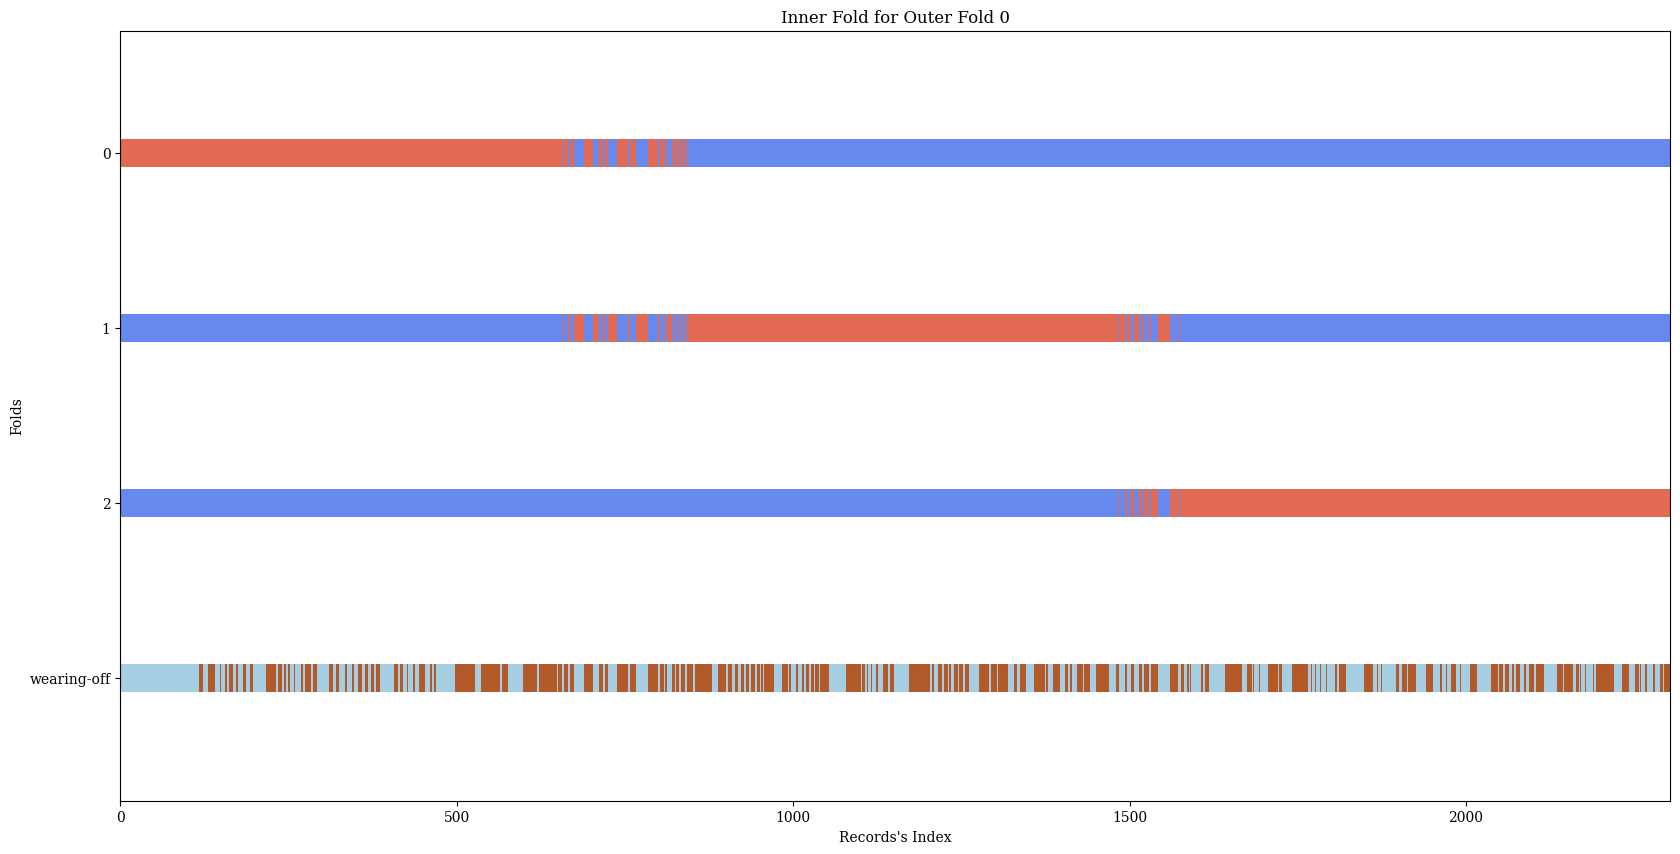

Train Sets for Outer Fold 0
Train Set for Inner Fold 0
[ 664  665  671 ... 2301 2302 2303]

Train Set for Inner Fold 1
[   0    1    2 ... 2301 2302 2303]

Train Set for Inner Fold 2
[   0    1    2 ... 1565 1575 1579]



In [10]:
# Inner CV
outer_fold_number = 0

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=3, shuffle=False)
plot_cv_indices(cv, X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]], ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title(f'Inner Fold for Outer Fold {outer_fold_number}')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

inner_training_folds = []
print(f'Train Sets for Outer Fold {outer_fold_number}')
for train, test in cv.split(X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]]):
    print(f'Train Set for Inner Fold {len(inner_training_folds)}')
    print(train)
    inner_training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

# Pipeline

## Define learning algorithms

In [11]:
estimator_selection = Switch('estimators')
estimator_selection += PipelineElement("LogisticRegression",
                           hyperparameters={
                               'C': FloatRange(1, 10)
                           }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement("DecisionTreeClassifier",
                           hyperparameters={
                               'min_samples_split': IntegerRange(2,30),
                               'min_samples_leaf': IntegerRange(2,30)
                           }, random_state=4, criterion='gini')
estimator_selection += PipelineElement('LinearSVC',
                            hyperparameters={
                                'C': FloatRange(1, 25)
                            }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement('RandomForestClassifier', 
                            hyperparameters={
                                'min_samples_split': IntegerRange(2,30),
                                'max_features': ['auto', 'sqrt', 'log2']
                            }, random_state=4, criterion='gini', bootstrap=True)
estimator_selection += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            }, random_state=4)

## Initial Pipeline

In [12]:
initial_pipeline = Hyperpipe('1 - Initial Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

# Add learning algorithms to compare
initial_pipeline += estimator_selection

# Fit hyperpipe
initial_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(initial_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(initial_pipeline)

# # View CV splits for debugging
# for k,v in initial_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(initial_pipeline)

12/06/2025-02:38:20 | Output Folder: ./analysis/participant1_15min\1InitialPipeline_results_2025-06-12_02-38-20
PHOTONAI ANALYSIS: 1InitialPipeline
12/06/2025-02:38:20 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-02:38:20 | Checking input data...
12/06/2025-02:38:20 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
12/06/2025-02:38:20 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-02:38:20 | Preparing data for outer fold 1...
12/06/2025-02:38:20 | Preparing Hyperparameter Optimization...
12/06/2025-02:38:20 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "LogisticRegression__C=9.105593099632042",
        "estimator_n

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:38:36 | Computed configuration 96/150 in 0:00:00.182241
12/06/2025-02:38:36 | Performance:             balanced_accuracy - Train: 0.8875, Validation: 0.6817
12/06/2025-02:38:36 | Best Performance So Far: balanced_accuracy - Train: 0.8312, Validation: 0.7301
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:38:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:38:36 | Computed configuration 97/150 in 0:00:00.233393
12/06/2025-02:38:36 | Performance:             balanced_accuracy - Train: 0.9715, Validation: 0.6753
12/06/2025-02:38:36 | Best Performance So Far: balanced_accuracy - Train: 0.8312, Validation: 0.7301
------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:38:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:38:38 | Computed configuration 102/150 in 0:00:00.186998
12/06/2025-02:38:38 | Performance:             balanced_accuracy - Train: 0.9057, Validation: 0.6831
12/06/2025-02:38:38 | Best Performance So Far: balanced_accuracy - Train: 0.8312, Validation: 0.7301
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:38:38 | Skipped

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=13",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:38:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:38:40 | Computed configuration 109/150 in 0:00:00.192425
12/06/2025-02:38:40 | Performance:             balanced_accuracy - Train: 0.9278, Validation: 0.6740
12/06/2025-02:38:40 | Best Performance So Far: balanced_accuracy - Train: 0.8312, Validation: 0.7301
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:38:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:38:41 | Computed configuration 111/150 in 0:00:00.197721
12/06/2025-02:38:41 | Performance:             balanced_accuracy - Train: 0.9337, Validation: 0.6714
12/06/2025-02:38:41 | Best Performance So Far: balanced_accuracy - Train: 0.8312, Validation: 0.7301
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:38:42 | Skipped

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:38:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:38:44 | Computed configuration 117/150 in 0:00:00.184000
12/06/2025-02:38:44 | Performance:             balanced_accuracy - Train: 0.9213, Validation: 0.6740
12/06/2025-02:38:44 | Best Performance So Far: balanced_accuracy - Train: 0.8312, Validation: 0.7301
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:38:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:38:44 | Computed configuration 119/150 in 0:00:00.196907
12/06/2025-02:38:44 | Performance:             balanced_accuracy - Train: 0.9604, Validation: 0.6753
12/06/2025-02:38:44 | Best Performance So Far: balanced_accuracy - Train: 0.8312, Validation: 0.7301
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:38:45 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:38:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:38:46 | Computed configuration 125/150 in 0:00:00.209506
12/06/2025-02:38:46 | Performance:             balanced_accuracy - Train: 0.8672, Validation: 0.6964
12/06/2025-02:38:46 | Best Performance So Far: balanced_accuracy - Train: 0.8312, Validation: 0.7301
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
   

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:38:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:38:46 | Computed configuration 129/150 in 0:00:00.217105
12/06/2025-02:38:46 | Performance:             balanced_accuracy - Train: 0.7932, Validation: 0.7161
12/06/2025-02:38:46 | Best Performance So Far: balanced_accuracy - Train: 0.8312, Validation: 0.7301
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:38:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:38:46 | Computed configuration 130/150 in 0:00:00.213006
12/06/2025-02:38:46 | Performance:             balanced_accuracy - Train: 0.9324, Validation: 0.6863
12/

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:39:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:13 | Computed configuration 96/150 in 0:00:00.246001
12/06/2025-02:39:13 | Performance:             balanced_accuracy - Train: 0.8888, Validation: 0.7341
12/06/2025-02:39:13 | Best Performance So Far: balanced_accuracy - Train: 0.8765, Validation: 0.7461
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:13 | Computed configuration 97/150 in 0:00:00.233873
12/06/2025-02:39:13 | Performance:             balanced_accuracy - Train: 0.9747, Validation: 0.7289
12/06/2025-02:39:13 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:14 | Computed configuration 102/150 in 0:00:00.282499
12/06/2025-02:39:14 | Performance:             balanced_accuracy - Train: 0.9656, Validation: 0.7394
12/06/2025-02:39:14 | Best Performance So Far: balanced_accuracy - Train: 0.9493, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:15 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:20 | Computed configuration 113/150 in 0:00:00.254467
12/06/2025-02:39:20 | Performance:             balanced_accuracy - Train: 0.9051, Validation: 0.7382
12/06/2025-02:39:20 | Best Performance So Far: balanced_accuracy - Train: 0.9493, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:20 | Skipped

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:22 | Computed configuration 117/150 in 0:00:00.332515
12/06/2025-02:39:22 | Performance:             balanced_accuracy - Train: 0.9941, Validation: 0.7329
12/06/2025-02:39:22 | Best Performance So Far: balanced_accuracy - Train: 0.9493, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:23 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:23 | Computed configuration 119/150 in 0:00:00.324986
12/06/2025-02:39:23 | Performance:             balanced_accuracy - Train: 0.9656, Validation: 0.7394
12/06/2025-02:39:23 | Best Performance So Far: balanced_accuracy - Train: 0.9493, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:24 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:39:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:25 | Computed configuration 125/150 in 0:00:00.297000
12/06/2025-02:39:25 | Performance:             balanced_accuracy - Train: 0.8731, Validation: 0.7445
12/06/2025-02:39:25 | Best Performance So Far: balanced_accuracy - Train: 0.9493, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
   

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:39:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:25 | Computed configuration 129/150 in 0:00:00.320424
12/06/2025-02:39:25 | Performance:             balanced_accuracy - Train: 0.7933, Validation: 0.7155
12/06/2025-02:39:25 | Best Performance So Far: balanced_accuracy - Train: 0.9493, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:39:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:26 | Computed configuration 130/150 in 0:00:00.272127
12/06/2025-02:39:26 | Performance:             balanced_accuracy - Train: 0.9357, Validation: 0.7171
12/

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:39:55 | Computed configuration 96/150 in 0:00:00.183717
12/06/2025-02:39:55 | Performance:             balanced_accuracy - Train: 0.9077, Validation: 0.6890
12/06/2025-02:39:55 | Best Performance So Far: balanced_accuracy - Train: 0.7147, Validation: 0.7486
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:55 | Computed configuration 97/150 in 0:00:00.199324
12/06/2025-02:39:55 | Performance:             balanced_accuracy - Train: 0.9753, Validation: 0.6773
12/06/2025-02:39:55 | Best Performance So Far: balanced_accuracy - Train: 0.7147, Validation: 0.7486
------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:39:56 | Computed configuration 102/150 in 0:00:00.182921
12/06/2025-02:39:56 | Performance:             balanced_accuracy - Train: 0.9135, Validation: 0.6786
12/06/2025-02:39:56 | Best Performance So Far: balanced_accuracy - Train: 0.7147, Validation: 0.7486
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=26",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:39:57 | Skipped

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:01 | Computed configuration 112/150 in 0:00:00.194519
12/06/2025-02:40:01 | Performance:             balanced_accuracy - Train: 0.9473, Validation: 0.6694
12/06/2025-02:40:01 | Best Performance So Far: balanced_accuracy - Train: 0.7147, Validation: 0.7486
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:01 | Computed configuration 114/150 in 0:00:00.195625
12/06/2025-02:40:01 | Performance:             balanced_accuracy - Train: 0.9239, Validation: 0.6824
12/06/2025-02:40:01 | Best Performance So Far: balanced_accuracy - Train: 0.7147, Validation: 0.7486
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=5",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:02 | Computed configuration 117/150 in 0:00:00.191000
12/06/2025-02:40:02 | Performance:             balanced_accuracy - Train: 0.9343, Validation: 0.6759
12/06/2025-02:40:02 | Best Performance So Far: balanced_accuracy - Train: 0.7147, Validation: 0.7486
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:03 | Computed configuration 119/150 in 0:00:00.198993
12/06/2025-02:40:03 | Performance:             balanced_accuracy - Train: 0.9747, Validation: 0.6655
12/06/2025-02:40:03 | Best Performance So Far: balanced_accuracy - Train: 0.7147, Validation: 0.7486
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:03 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:40:05 | Computed configuration 125/150 in 0:00:00.206085
12/06/2025-02:40:05 | Performance:             balanced_accuracy - Train: 0.8761, Validation: 0.6771
12/06/2025-02:40:05 | Best Performance So Far: balanced_accuracy - Train: 0.7147, Validation: 0.7486
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:40:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:05 | Computed configuration 129/150 in 0:00:00.213019
12/06/2025-02:40:05 | Performance:             balanced_accuracy - Train: 0.8006, Validation: 0.7172
12/06/2025-02:40:05 | Best Performance So Far: balanced_accuracy - Train: 0.7147, Validation: 0.7486
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:40:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:05 | Computed configuration 130/150 in 0:00:00.207522
12/06/2025-02:40:05 | Performance:             balanced_accuracy - Train: 0.9486, Validation: 0.6965
12/

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:40:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:30 | Computed configuration 96/150 in 0:00:00.180509
12/06/2025-02:40:30 | Performance:             balanced_accuracy - Train: 0.9115, Validation: 0.6751
12/06/2025-02:40:30 | Best Performance So Far: balanced_accuracy - Train: 0.8807, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:30 | Computed configuration 97/150 in 0:00:00.199524
12/06/2025-02:40:30 | Performance:             balanced_accuracy - Train: 0.9780, Validation: 0.6736
12/06/2025-02:40:30 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:32 | Computed configuration 102/150 in 0:00:00.228014
12/06/2025-02:40:32 | Performance:             balanced_accuracy - Train: 0.9728, Validation: 0.6788
12/06/2025-02:40:32 | Best Performance So Far: balanced_accuracy - Train: 0.8807, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:32 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:37 | Computed configuration 112/150 in 0:00:00.244018
12/06/2025-02:40:37 | Performance:             balanced_accuracy - Train: 0.9981, Validation: 0.6737
12/06/2025-02:40:37 | Best Performance So Far: balanced_accuracy - Train: 0.8807, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:37 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:38 | Computed configuration 115/150 in 0:00:00.205938
12/06/2025-02:40:38 | Performance:             balanced_accuracy - Train: 0.9057, Validation: 0.6815
12/06/2025-02:40:38 | Best Performance So Far: balanced_accuracy - Train: 0.8807, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:40:39 | Skipped

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:40:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:42 | Computed configuration 125/150 in 0:00:00.288424
12/06/2025-02:40:42 | Performance:             balanced_accuracy - Train: 0.8888, Validation: 0.7296
12/06/2025-02:40:42 | Best Performance So Far: balanced_accuracy - Train: 0.8807, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
   

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:40:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:43 | Computed configuration 129/150 in 0:00:00.237411
12/06/2025-02:40:43 | Performance:             balanced_accuracy - Train: 0.7917, Validation: 0.7429
12/06/2025-02:40:43 | Best Performance So Far: balanced_accuracy - Train: 0.8807, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:40:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:40:43 | Computed configuration 130/150 in 0:00:00.263297
12/06/2025-02:40:43 | Performance:             balanced_accuracy - Train: 0.9532, Validation: 0.7220
12/

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:41:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:12 | Computed configuration 96/150 in 0:00:00.181018
12/06/2025-02:41:12 | Performance:             balanced_accuracy - Train: 0.9091, Validation: 0.6513
12/06/2025-02:41:12 | Best Performance So Far: balanced_accuracy - Train: 0.7173, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:12 | Computed configuration 97/150 in 0:00:00.191008
12/06/2025-02:41:12 | Performance:             balanced_accuracy - Train: 0.9773, Validation: 0.6434
12/06/2025-02:41:12 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:13 | Computed configuration 102/150 in 0:00:00.189000
12/06/2025-02:41:13 | Performance:             balanced_accuracy - Train: 0.9214, Validation: 0.6436
12/06/2025-02:41:13 | Best Performance So Far: balanced_accuracy - Train: 0.7173, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:14 | Skipped

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=10",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:16 | Computed configuration 109/150 in 0:00:00.187001
12/06/2025-02:41:16 | Performance:             balanced_accuracy - Train: 0.9565, Validation: 0.6462
12/06/2025-02:41:16 | Best Performance So Far: balanced_accuracy - Train: 0.7173, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:17 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:17 | Computed configuration 111/150 in 0:00:00.169000
12/06/2025-02:41:17 | Performance:             balanced_accuracy - Train: 0.9085, Validation: 0.6645
12/06/2025-02:41:17 | Best Performance So Far: balanced_accuracy - Train: 0.7173, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:17 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:17 | Computed configuration 113/150 in 0:00:00.179515
12/06/2025-02:41:17 | Performance:             balanced_accuracy - Train: 0.9299, Validation: 0.6280
12/06/2025-02:41:17 | Best Performance So Far: balanced_accuracy - Train: 0.7173, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:18 | Skipped

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:20 | Computed configuration 119/150 in 0:00:00.183996
12/06/2025-02:41:20 | Performance:             balanced_accuracy - Train: 0.9182, Validation: 0.6500
12/06/2025-02:41:20 | Best Performance So Far: balanced_accuracy - Train: 0.7173, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:20 | Skipped

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:41:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:21 | Computed configuration 125/150 in 0:00:00.209084
12/06/2025-02:41:21 | Performance:             balanced_accuracy - Train: 0.8881, Validation: 0.7087
12/06/2025-02:41:21 | Best Performance So Far: balanced_accuracy - Train: 0.7959, Validation: 0.7378
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
   

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:41:22 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-02:41:22 | Computed configuration 129/150 in 0:00:00.422524
12/06/2025-02:41:22 | Performance:             balanced_accuracy - Train: 0.8094, Validation: 0.7255
12/06/2025-02:41:22 | Best Performance So Far: balanced_accuracy - Train: 0.7959, Validation: 0.7378
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:41:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:22 | Computed configuration 130/150 in 0:00:00.204999
12/06/2025-02:41:22 | Performance:             balanced_accuracy - Train: 0.9545, Validation: 0.7178
12/

## Feature Selection Pipeline

In [13]:
classifier = LogisticRegression(random_state=4).fit(X, y)

feature_selection_pipeline = Hyperpipe('2 - Feature Selection Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

feature_selection_pipeline += estimator_selection

# Fit hyperpipe
feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(feature_selection_pipeline)

12/06/2025-02:41:34 | Output Folder: ./analysis/participant1_15min\2FeatureSelectionPipline_results_2025-06-12_02-41-34
PHOTONAI ANALYSIS: 2FeatureSelectionPipline
12/06/2025-02:41:34 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-02:41:34 | Checking input data...
12/06/2025-02:41:34 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
JsonTransformer was unable to create the .json file.
12/06/2025-02:41:34 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-02:41:34 | Preparing data for outer fold 1...
12/06/2025-02:41:34 | Preparing Hyperparameter Optimization...
12/06/2025-02:41:34 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:41:52 | Computed configuration 96/150 in 0:00:00.180505
12/06/2025-02:41:52 | Performance:             balanced_accuracy - Train: 0.8986, Validation: 0.6843
12/06/2025-02:41:52 | Best Performance So Far: balanced_accuracy - Train: 0.8588, Validation: 0.7308
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:52 | Computed configuration 97/150 in 0:00:00.176993
12/06/2025-02:41:52 | Performance:             balanced_accuracy - Train: 0.8686, Validation: 0.7334
12/06/2025-02:41:52 | Best Performance So Far: balanced_accuracy - Train: 0.8686, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:41:53 | Computed configuration 100/150 in 0:00:00.179000
12/06/2025-02:41:53 | Performance:             balanced_accuracy - Train: 0.8875, Validation: 0.6817
12/06/2025-02:41:53 | Best Performance So Far: balanced_accuracy - Train: 0.8686, Validation: 0.7334
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:41:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:41:53 | Computed configuration 101/150 in 0:00:00.113909
12/06/2025-02:41:53 | Performance:             balanced_accuracy - Train: 0.5969, Validation: 0.4239
12/06/2025-02:41:53 | Best Performance So Far: balanced_accuracy - Train: 0.8686, Validation:

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.21784558636141854",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python3

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:42:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:02 | Computed configuration 128/150 in 0:00:00.129309
12/06/2025-02:42:02 | Performance:             balanced_accuracy - Train: 0.7366, Validation: 0.7291
12/06/2025-02:42:02 | Best Performance So Far: balanced_accuracy - Train: 0.7529, Validation: 0.7355
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.39707074960577515",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:42:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:03 | Computed configuration 129/150 in 0:00:00.212002
12/06/2025-02:42:03 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:42:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:03 | Computed configuration 131/150 in 0:00:00.102998
12/06/2025-02:42:03 | Performance:             balanced_accuracy - Train: 0.5969, Validation: 0.4239
12/06/2025-02:42:03 | Best Performance So Far: balanced_accuracy - Train: 0.7529, Validation: 0.7355
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=6"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0017515576101357077",
        "estimator_name=GradientBoo

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:42:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:29 | Computed configuration 96/150 in 0:00:00.204481
12/06/2025-02:42:29 | Performance:             balanced_accuracy - Train: 0.9005, Validation: 0.7132
12/06/2025-02:42:29 | Best Performance So Far: balanced_accuracy - Train: 0.8849, Validation: 0.7368
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:42:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:29 | Computed configuration 97/150 in 0:00:00.187006
12/06/2025-02:42:29 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:42:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:29 | Computed configuration 100/150 in 0:00:00.189013
12/06/2025-02:42:29 | Performance:             balanced_accuracy - Train: 0.8888, Validation: 0.7341
12/06/2025-02:42:29 | Best Performance So Far: balanced_accuracy - Train: 0.8849, Validation: 0.7368
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:42:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:29 | Computed configuration 101/150 in 0:00:00.116016
12/06/2025-02:42:29 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:42:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:40 | Computed configuration 122/150 in 0:00:00.222547
12/06/2025-02:42:40 | Performance:             balanced_accuracy - Train: 0.7528, Validation: 0.7294
12/06/2025-02:42:40 | Best Performance So Far: balanced_accuracy - Train: 0.8836, Validation: 0.7394
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\phot

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:42:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:40 | Computed configuration 125/150 in 0:00:00.185999
12/06/2025-02:42:40 | Performance:             balanced_accuracy - Train: 0.7519, Validation: 0.7217
12/06/2025-02:42:40 | Best Performance So Far: balanced_accuracy - Train: 0.8836, Validation: 0.7394
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\phot

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:42:40 | Computed configuration 127/150 in 0:00:00.190375
12/06/2025-02:42:40 | Performance:             balanced_accuracy - Train: 0.7432, Validation: 0.7243
12/06/2025-02:42:40 | Best Performance So Far: balanced_accuracy - Train: 0.8836, Validation: 0.7394
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:42:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:40 | Computed configuration 128/150 in 0:00:00.151968
12/06/2025-02:42:40 | Performance:             balanced_accuracy - Train: 0.7365, Validation: 0.7244
12/06/2025-02:42:40 | Best Performance So Far: balanced_accuracy - T

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:42:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:42:41 | Computed configuration 131/150 in 0:00:00.099086
12/06/2025-02:42:41 | Performance:             balanced_accuracy - Train: 0.5977, Validation: 0.4268
12/06/2025-02:42:41 | Best Performance So Far: balanced_accuracy - Train: 0.8836, Validation: 0.7394
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=6"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:43:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:09 | Computed configuration 96/150 in 0:00:00.199948
12/06/2025-02:43:09 | Performance:             balanced_accuracy - Train: 0.9135, Validation: 0.6786
12/06/2025-02:43:09 | Best Performance So Far: balanced_accuracy - Train: 0.6998, Validation: 0.7500
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:43:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:10 | Computed configuration 97/150 in 0:00:00.195542
12/06/2025-02:43:10 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:43:10 | Computed configuration 100/150 in 0:00:00.204001
12/06/2025-02:43:10 | Performance:             balanced_accuracy - Train: 0.9077, Validation: 0.6890
12/06/2025-02:43:10 | Best Performance So Far: balanced_accuracy - Train: 0.6998, Validation: 0.7500
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:43:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:10 | Computed configuration 101/150 in 0:00:00.119999
12/06/2025-02:43:10 | Performance:             balanced_accuracy - Train: 0.6482, Validation: 0.4925
12/06/2025-02:43:10 | Best Performance So Far: balanced_accuracy - Train: 0.6998, Validation:

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:43:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:16 | Computed configuration 113/150 in 0:00:00.263901
12/06/2025-02:43:16 | Performance:             balanced_accuracy - Train: 0.8979, Validation: 0.6889
12/06/2025-02:43:16 | Best Performance So Far: balanced_accuracy - Train: 0.6998, Validation: 0.7500
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:43:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:20 | Computed configuration 120/150 in 0:00:00.253544
12/06/2025-02:43:20 | Performance:             balanced_accuracy - Train: 0.8893, Validation: 0.6531
12/06/2025-02:43:20 | Best Performance So Far: balanced_accuracy - Train: 0.6998, Validation: 0.7500
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:43:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:20 | Computed configuration 122/150 in 0:00:00.226513
12/06/2025-02:43:20 | Performance:             balanced_accuracy - Train: 0.7947, Validation: 0.7172
12/06/2025-02:43:20 | Best Performance So Far: balanced_accuracy - Train: 0.6998, Validation: 0.7500
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\phot

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:43:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:21 | Computed configuration 125/150 in 0:00:00.195000
12/06/2025-02:43:21 | Performance:             balanced_accuracy - Train: 0.8003, Validation: 0.6925
12/06/2025-02:43:21 | Best Performance So Far: balanced_accuracy - Train: 0.6998, Validation: 0.7500
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\phot

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:43:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:21 | Computed configuration 128/150 in 0:00:00.122041
12/06/2025-02:43:21 | Performance:             balanced_accuracy - Train: 0.7672, Validation: 0.6672
12/06/2025-02:43:21 | Best Performance So Far: balanced_accuracy - Train: 0.6998, Validation: 0.7500
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.39707074960577515",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:43:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:21 | Computed configuration 129/150 in 0:00:00.210071
12/06/2025-02:43:21 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:43:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:21 | Computed configuration 131/150 in 0:00:00.087999
12/06/2025-02:43:21 | Performance:             balanced_accuracy - Train: 0.6482, Validation: 0.4987
12/06/2025-02:43:21 | Best Performance So Far: balanced_accuracy - Train: 0.6998, Validation: 0.7500
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=6"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0017515576101357077",
        "estimator_name=GradientBoo

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:43:50 | Computed configuration 96/150 in 0:00:00.185967
12/06/2025-02:43:50 | Performance:             balanced_accuracy - Train: 0.9148, Validation: 0.6725
12/06/2025-02:43:50 | Best Performance So Far: balanced_accuracy - Train: 0.8450, Validation: 0.7485
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:43:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:51 | Computed configuration 97/150 in 0:00:00.197961
12/06/2025-02:43:51 | Performance:             balanced_accuracy - Train: 0.9141, Validation: 0.7199
12/06/2025-02:43:51 | Best Performance So Far: balanced_accuracy - Train: 0.8450, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:43:51 | Computed configuration 100/150 in 0:00:00.185503
12/06/2025-02:43:51 | Performance:             balanced_accuracy - Train: 0.9115, Validation: 0.6751
12/06/2025-02:43:51 | Best Performance So Far: balanced_accuracy - Train: 0.8450, Validation: 0.7485
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:43:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:43:51 | Computed configuration 101/150 in 0:00:00.173104
12/06/2025-02:43:51 | Performance:             balanced_accuracy - Train: 0.8350, Validation: 0.5451
12/06/2025-02:43:51 | Best Performance So Far: balanced_accuracy - Train: 0.8450, Validation:

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:44:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:00 | Computed configuration 122/150 in 0:00:00.212951
12/06/2025-02:44:00 | Performance:             balanced_accuracy - Train: 0.7967, Validation: 0.7095
12/06/2025-02:44:00 | Best Performance So Far: balanced_accuracy - Train: 0.8450, Validation: 0.7485
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\phot

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:44:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:00 | Computed configuration 125/150 in 0:00:00.191966
12/06/2025-02:44:00 | Performance:             balanced_accuracy - Train: 0.7819, Validation: 0.7470
12/06/2025-02:44:00 | Best Performance So Far: balanced_accuracy - Train: 0.8450, Validation: 0.7485
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\phot

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:44:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:00 | Computed configuration 127/150 in 0:00:00.199387
12/06/2025-02:44:00 | Performance:             balanced_accuracy - Train: 0.7807, Validation: 0.7418
12/06/2025-02:44:00 | Best Performance So Far: balanced_accuracy - Train: 0.8450, Validation: 0.7485
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:44:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:01 | Computed configuration 128/150 in 0:00:00.198104
12/06/2025-02:44:01 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:44:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:01 | Computed configuration 131/150 in 0:00:00.158975
12/06/2025-02:44:01 | Performance:             balanced_accuracy - Train: 0.8220, Validation: 0.5136
12/06/2025-02:44:01 | Best Performance So Far: balanced_accuracy - Train: 0.8450, Validation: 0.7485
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.009822150865128264",
        "estimator_name=GradientBoos

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:44:29 | Computed configuration 96/150 in 0:00:00.175970
12/06/2025-02:44:29 | Performance:             balanced_accuracy - Train: 0.9195, Validation: 0.6462
12/06/2025-02:44:29 | Best Performance So Far: balanced_accuracy - Train: 0.7238, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:44:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:30 | Computed configuration 97/150 in 0:00:00.157958
12/06/2025-02:44:30 | Performance:             balanced_accuracy - Train: 0.8864, Validation: 0.6691
12/06/2025-02:44:30 | Best Performance So Far: balanced_accuracy - Train: 0.7238, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:44:30 | Performance:             balanced_accuracy - Train: 0.9091, Validation: 0.6513
12/06/2025-02:44:30 | Best Performance So Far: balanced_accuracy - Train: 0.7238, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:44:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:30 | Computed configuration 101/150 in 0:00:00.111747
12/06/2025-02:44:30 | Performance:             balanced_accuracy - Train: 0.6411, Validation: 0.4212
12/06/2025-02:44:30 | Best Performance So Far: balanced_accuracy - Train: 0.7238, Validation: 0.7362
---------------------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:44:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:35 | Computed configuration 113/150 in 0:00:00.177989
12/06/2025-02:44:35 | Performance:             balanced_accuracy - Train: 0.9137, Validation: 0.6630
12/06/2025-02:44:35 | Best Performance So Far: balanced_accuracy - Train: 0.7238, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:44:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:36 | Computed configuration 116/150 in 0:00:00.168975
12/06/2025-02:44:36 | Performance:             balanced_accuracy - Train: 0.8869, Validation: 0.6614
12/06/2025-02:44:36 | Best Performance So Far: balanced_accuracy - Train: 0.7238, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=3"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:44:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:38 | Computed configuration 120/150 in 0:00:00.134127
12/06/2025-02:44:38 | Performance:             balanced_accuracy - Train: 0.6411, Validation: 0.4281
12/06/2025-02:44:38 | Best Performance So Far: balanced_accuracy - Train: 0.7238, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:44:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:38 | Computed configuration 122/150 in 0:00:00.245138
12/06/2025-02:44:38 | Performance:             balanced_accuracy - Train: 0.7907, Validation: 0.7418
12/06/2025-02:44:38 | Best Performance So Far: balanced_accuracy - Train: 0.7907, Validation: 0.7418
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\phot

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:44:39 | Computed configuration 125/150 in 0:00:00.177017
12/06/2025-02:44:39 | Performance:             balanced_accuracy - Train: 0.7335, Validation: 0.5145
12/06/2025-02:44:39 | Best Performance So Far: balanced_accuracy - Train: 0.7907, Validation: 0.7418
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(j

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:44:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:39 | Computed configuration 128/150 in 0:00:00.152648
12/06/2025-02:44:39 | Performance:             balanced_accuracy - Train: 0.6986, Validation: 0.5920
12/06/2025-02:44:39 | Best Performance So Far: balanced_accuracy - Train: 0.7907, Validation: 0.7418
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.39707074960577515",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:44:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:39 | Computed configuration 129/150 in 0:00:00.232925
12/06/2025-02:44:39 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:44:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:44:40 | Computed configuration 131/150 in 0:00:00.118086
12/06/2025-02:44:40 | Performance:             balanced_accuracy - Train: 0.6411, Validation: 0.4281
12/06/2025-02:44:40 | Best Performance So Far: balanced_accuracy - Train: 0.7907, Validation: 0.7418
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=6"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

## Class Imbalanced Pipeline

In [14]:
class_imbalanced_pipeline = Hyperpipe('3 - Class Imbalanced Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_pipeline)

12/06/2025-02:44:53 | Output Folder: ./analysis/participant1_15min\3ClassImbalancedPipline_results_2025-06-12_02-44-53
PHOTONAI ANALYSIS: 3ClassImbalancedPipline
12/06/2025-02:44:53 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-02:44:53 | Checking input data...
12/06/2025-02:44:53 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
12/06/2025-02:44:53 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-02:44:53 | Preparing data for outer fold 1...
12/06/2025-02:44:53 | Preparing Hyperparameter Optimization...
12/06/2025-02:44:53 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:45:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:15 | Computed configuration 94/150 in 0:00:00.202965
12/06/2025-02:45:15 | Performance:             balanced_accuracy - Train: 0.9419, Validation: 0.6714
12/06/2025-02:45:15 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:45:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:15 | Computed configuration 95/150 in 0:00:00.201009
12/06/2025-02:45:15 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:45:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:15 | Computed configuration 99/150 in 0:00:00.216947
12/06/2025-02:45:15 | Performance:             balanced_accuracy - Train: 0.9974, Validation: 0.6805
12/06/2025-02:45:15 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\M

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:45:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:16 | Computed configuration 101/150 in 0:00:00.191963
12/06/2025-02:45:16 | Performance:             balanced_accuracy - Train: 0.9071, Validation: 0.6792
12/06/2025-02:45:16 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=25",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:45:19 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:19 | Computed configuration 108/150 in 0:00:00.183972
12/06/2025-02:45:19 | Performance:             balanced_accuracy - Train: 0.8916, Validation: 0.6765
12/06/2025-02:45:19 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=28"

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:45:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:21 | Computed configuration 113/150 in 0:00:00.189373
12/06/2025-02:45:21 | Performance:             balanced_accuracy - Train: 0.9181, Validation: 0.6727
12/06/2025-02:45:21 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__m

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", l

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(j

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:45:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:25 | Computed configuration 122/150 in 0:00:00.227962
12/06/2025-02:45:25 | Performance:             balanced_accuracy - Train: 0.7865, Validation: 0.7324
12/06/2025-02:45:25 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:45:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:25 | Computed configuration 123/150 in 0:00:00.212219
12/06/2025-02:45:25 |

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:45:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:25 | Computed configuration 125/150 in 0:00:00.218402
12/06/2025-02:45:25 | Performance:             balanced_accuracy - Train: 0.8077, Validation: 0.7252
12/06/2025-02:45:25 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:45:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:25 | Computed configuration 126/150 in 0:00:00.220966
12/06/2025-02:45:25 | 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:45:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:26 | Computed configuration 130/150 in 0:00:00.212964
12/06/2025-02:45:26 | Performance:             balanced_accuracy - Train: 0.9813, Validation: 0.6839
12/06/2025-02:45:26 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:45:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:26 | Computed configuration 131/150 in 0:00:00.220967
12/06/2025-02:45:26 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:45:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:56 | Computed configuration 94/150 in 0:00:00.202459
12/06/2025-02:45:56 | Performance:             balanced_accuracy - Train: 0.9433, Validation: 0.7251
12/06/2025-02:45:56 | Best Performance So Far: balanced_accuracy - Train: 0.8144, Validation: 0.7437
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:45:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:56 | Computed configuration 95/150 in 0:00:00.199921
12/06/2025-02:45:56 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:45:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:56 | Computed configuration 99/150 in 0:00:00.211967
12/06/2025-02:45:56 | Performance:             balanced_accuracy - Train: 0.9974, Validation: 0.7408
12/06/2025-02:45:56 | Best Performance So Far: balanced_accuracy - Train: 0.8144, Validation: 0.7437
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\M

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:45:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:45:57 | Computed configuration 101/150 in 0:00:00.212467
12/06/2025-02:45:57 | Performance:             balanced_accuracy - Train: 0.9664, Validation: 0.7160
12/06/2025-02:45:57 | Best Performance So Far: balanced_accuracy - Train: 0.8144, Validation: 0.7437
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifi

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", li

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:46:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:04 | Computed configuration 117/150 in 0:00:00.199507
12/06/2025-02:46:04 | Performance:             balanced_accuracy - Train: 0.8995, Validation: 0.7186
12/06/2025-02:46:04 | Best Performance So Far: balanced_accuracy - Train: 0.8144, Validation: 0.7437
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_sampl

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=25",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:46:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:05 | Computed configuration 119/150 in 0:00:00.199114
12/06/2025-02:46:05 | Performance:             balanced_accuracy - Train: 0.8905, Validation: 0.7381
12/06/2025-02:46:05 | Best Performance So Far: balanced_accuracy - Train: 0.8144, Validation: 0.7437
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__m

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:46:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:06 | Computed configuration 122/150 in 0:00:00.227965
12/06/2025-02:46:06 | Performance:             balanced_accuracy - Train: 0.7925, Validation: 0.7182
12/06/2025-02:46:06 | Best Performance So Far: balanced_accuracy - Train: 0.8144, Validation: 0.7437
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:46:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:06 | Computed configuration 123/150 in 0:00:00.220269
12/06/2025-02:46:06 |

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:46:07 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:07 | Computed configuration 125/150 in 0:00:00.231147
12/06/2025-02:46:07 | Performance:             balanced_accuracy - Train: 0.8099, Validation: 0.7440
12/06/2025-02:46:07 | Best Performance So Far: balanced_accuracy - Train: 0.8099, Validation: 0.7440
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:46:07 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:07 | Computed configuration 126/150 in 0:00:00.237265
12/06/2025-02:46:07 | 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:46:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:08 | Computed configuration 130/150 in 0:00:00.212484
12/06/2025-02:46:08 | Performance:             balanced_accuracy - Train: 0.9807, Validation: 0.7393
12/06/2025-02:46:08 | Best Performance So Far: balanced_accuracy - Train: 0.8099, Validation: 0.7440
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0844064265033311",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:46:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:08 | Computed configuration 131/150 in 0:00:00.211966
12/06/2025-02:46:08 |

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:46:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:44 | Computed configuration 94/150 in 0:00:00.227645
12/06/2025-02:46:44 | Performance:             balanced_accuracy - Train: 0.9568, Validation: 0.6863
12/06/2025-02:46:44 | Best Performance So Far: balanced_accuracy - Train: 0.7168, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:46:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:44 | Computed configuration 95/150 in 0:00:00.255552
12/06/2025-02:46:44 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:46:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:45 | Computed configuration 99/150 in 0:00:00.222963
12/06/2025-02:46:45 | Performance:             balanced_accuracy - Train: 0.9980, Validation: 0.6875
12/06/2025-02:46:45 | Best Performance So Far: balanced_accuracy - Train: 0.7168, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\M

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:46:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:45 | Computed configuration 101/150 in 0:00:00.230397
12/06/2025-02:46:45 | Performance:             balanced_accuracy - Train: 0.9239, Validation: 0.6863
12/06/2025-02:46:45 | Best Performance So Far: balanced_accuracy - Train: 0.7168, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:46:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:55 | Computed configuration 122/150 in 0:00:00.228926
12/06/2025-02:46:55 | Performance:             balanced_accuracy - Train: 0.7665, Validation: 0.7185
12/06/2025-02:46:55 | Best Performance So Far: balanced_accuracy - Train: 0.7168, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:46:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:55 | Computed configuration 123/150 in 0:00:00.216501
12/06/2025-02:46:55 |

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:46:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:55 | Computed configuration 125/150 in 0:00:00.222962
12/06/2025-02:46:55 | Performance:             balanced_accuracy - Train: 0.8110, Validation: 0.7355
12/06/2025-02:46:55 | Best Performance So Far: balanced_accuracy - Train: 0.7168, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:46:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:55 | Computed configuration 126/150 in 0:00:00.222480
12/06/2025-02:46:55 | 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:46:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:56 | Computed configuration 130/150 in 0:00:00.220212
12/06/2025-02:46:56 | Performance:             balanced_accuracy - Train: 0.9865, Validation: 0.6417
12/06/2025-02:46:56 | Best Performance So Far: balanced_accuracy - Train: 0.7168, Validation: 0.7460
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.015966509444436554",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:46:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:46:57 | Computed configuration 131/150 in 0:00:00.213968
12/06/2025-02:46:57 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:47:26 | Computed configuration 94/150 in 0:00:00.191506
12/06/2025-02:47:26 | Performance:             balanced_accuracy - Train: 0.9516, Validation: 0.6685
12/06/2025-02:47:26 | Best Performance So Far: balanced_accuracy - Train: 0.8742, Validation: 0.7434
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:47:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:47:26 | Computed configuration 95/150 in 0:00:00.196040
12/06/2025-02:47:26 | Performance:             balanced_accuracy - Train: 0.9402, Validation: 0.6802
12/06/2025-02:47:26 | Best Performance So Far: balanced_accuracy 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:47:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:47:27 | Computed configuration 99/150 in 0:00:00.227964
12/06/2025-02:47:27 | Performance:             balanced_accuracy - Train: 0.9980, Validation: 0.6790
12/06/2025-02:47:27 | Best Performance So Far: balanced_accuracy - Train: 0.8742, Validation: 0.7434
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\M

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:47:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:47:27 | Computed configuration 101/150 in 0:00:00.205378
12/06/2025-02:47:27 | Performance:             balanced_accuracy - Train: 0.9777, Validation: 0.6763
12/06/2025-02:47:27 | Best Performance So Far: balanced_accuracy - Train: 0.8742, Validation: 0.7434
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_sampl

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:47:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:47:37 | Computed configuration 122/150 in 0:00:00.216970
12/06/2025-02:47:37 | Performance:             balanced_accuracy - Train: 0.7819, Validation: 0.6599
12/06/2025-02:47:37 | Best Performance So Far: balanced_accuracy - Train: 0.8742, Validation: 0.7434
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:47:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:47:37 | Computed configuration 123/150 in 0:00:00.208239
12/06/2025-02:47:37 |

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:47:38 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-02:47:38 | Computed configuration 125/150 in 0:00:00.449927
12/06/2025-02:47:38 | Performance:             balanced_accuracy - Train: 0.8206, Validation: 0.7220
12/06/2025-02:47:38 | Best Performance So Far: balanced_accuracy - Train: 0.8742, Validation: 0.7434
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:47:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:47:38 | Computed configuration 126/150 in 0:00:00.217522
12/06/2025-02:47:38 | 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:47:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:47:38 | Computed configuration 130/150 in 0:00:00.210779
12/06/2025-02:47:38 | Performance:             balanced_accuracy - Train: 0.9877, Validation: 0.6895
12/06/2025-02:47:38 | Best Performance So Far: balanced_accuracy - Train: 0.8469, Validation: 0.7496
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0844064265033311",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:47:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:47:39 | Computed configuration 131/150 in 0:00:00.209578
12/06/2025-02:47:39 |

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:48:08 | Computed configuration 94/150 in 0:00:00.194502
12/06/2025-02:48:08 | Performance:             balanced_accuracy - Train: 0.9555, Validation: 0.6304
12/06/2025-02:48:08 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:48:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:48:09 | Computed configuration 95/150 in 0:00:00.205751
12/06/2025-02:48:09 | Performance:             balanced_accuracy - Train: 0.9488, Validation: 0.6460
12/06/2025-02:48:09 | Best Performance So Far: balanced_accuracy 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:48:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:48:09 | Computed configuration 99/150 in 0:00:00.267222
12/06/2025-02:48:09 | Performance:             balanced_accuracy - Train: 0.9987, Validation: 0.6459
12/06/2025-02:48:09 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\M

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:48:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:48:10 | Computed configuration 101/150 in 0:00:00.214556
12/06/2025-02:48:10 | Performance:             balanced_accuracy - Train: 0.9252, Validation: 0.6177
12/06/2025-02:48:10 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:48:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:48:16 | Computed configuration 113/150 in 0:00:00.214954
12/06/2025-02:48:16 | Performance:             balanced_accuracy - Train: 0.9355, Validation: 0.6395
12/06/2025-02:48:16 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__m

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", l

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(j

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:48:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:48:21 | Computed configuration 122/150 in 0:00:00.227968
12/06/2025-02:48:21 | Performance:             balanced_accuracy - Train: 0.7948, Validation: 0.7418
12/06/2025-02:48:21 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:48:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:48:21 | Computed configuration 123/150 in 0:00:00.288051
12/06/2025-02:48:21 |

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:48:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:48:21 | Computed configuration 125/150 in 0:00:00.259401
12/06/2025-02:48:21 | Performance:             balanced_accuracy - Train: 0.8277, Validation: 0.7482
12/06/2025-02:48:21 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:48:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:48:21 | Computed configuration 126/150 in 0:00:00.284586
12/06/2025-02:48:21 | 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:48:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:48:22 | Computed configuration 130/150 in 0:00:00.256873
12/06/2025-02:48:22 | Performance:             balanced_accuracy - Train: 0.9877, Validation: 0.6946
12/06/2025-02:48:22 | Best Performance So Far: balanced_accuracy - Train: 0.8477, Validation: 0.7499
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.00848293176648912",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:48:23 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-02:48:23 | Computed configuration 131/150 in 0:00:00.538540
12/06/2025-02:48:23 

## Class Imbalanced + Feature Selection Pipeline

In [15]:
classifier = LogisticRegression(random_state=4).fit(X, y)

class_imbalanced_feature_selection_pipeline = Hyperpipe('4 - CI and FS Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])


tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_feature_selection_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

class_imbalanced_feature_selection_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_feature_selection_pipeline)

12/06/2025-02:48:38 | Output Folder: ./analysis/participant1_15min\4CIandFSPipeline_results_2025-06-12_02-48-38
PHOTONAI ANALYSIS: 4CIandFSPipeline
12/06/2025-02:48:38 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-02:48:38 | Checking input data...
12/06/2025-02:48:38 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
JsonTransformer was unable to create the .json file.
12/06/2025-02:48:38 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-02:48:38 | Preparing data for outer fold 1...
12/06/2025-02:48:38 | Preparing Hyperparameter Optimization...
12/06/2025-02:48:38 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
   

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:49:01 | Performance:             balanced_accuracy - Train: 0.8666, Validation: 0.7308
12/06/2025-02:49:01 | Best Performance So Far: balanced_accuracy - Train: 0.8666, Validation: 0.7308
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:49:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:01 | Computed configuration 94/150 in 0:00:00.173273
12/06/2025-02:49:01 | Performance:             balanced_accuracy - Train: 0.8961, Validation: 0.7047
12/06/2025-02:49:01 | Best Performance So Far: balanced_accuracy - Train: 0.8666, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:49:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:02 | Computed configuration 98/150 in 0:00:00.276628
12/06/2025-02:49:02 | Performance:             balanced_accuracy - Train: 0.5961, Validation: 0.4565
12/06/2025-02:49:02 | Best Performance So Far: balanced_accuracy - Train: 0.8666, Validation: 0.7308
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:49:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:03 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:49:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:04 | Computed configuration 103/150 in 0:00:00.267171
12/06/2025-02:49:04 | Performance:             balanced_accuracy - Train: 0.8732, Validation: 0.7178
12/06/2025-02:49:04 | Best Performance So Far: balanced_accuracy - Train: 0.8666, Validation: 0.7308
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:49:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:13 | Computed configuration 127/150 in 0:00:00.098983
12/06/2025-02:49:13 | Performance:             balanced_accuracy - Train: 0.5802, Validation: 0.4604
12/06/2025-02:49:13 | Best Performance So Far: balanced_accuracy - Train: 0.8673, Validation: 0.7359
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.01680086261350344",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:49:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:13 | Computed configu

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:49:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:13 | Computed configuration 131/150 in 0:00:00.184318
12/06/2025-02:49:13 | Performance:             balanced_accuracy - Train: 0.7968, Validation: 0.7147
12/06/2025-02:49:13 | Best Performance So Far: balanced_accuracy - Train: 0.8673, Validation: 0.7359
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:49:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:52 | Computed configuration 93/150 in 0:00:00.240954
12/06/2025-02:49:52 | Performance:             balanced_accuracy - Train: 0.8678, Validation: 0.7050
12/06/2025-02:49:52 | Best Performance So Far: balanced_accuracy - Train: 0.8705, Validation: 0.7448
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:49:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:52 | Computed configuration 94/150 in 0:00:00.263192
12/06/

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:49:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:53 | Computed configuration 98/150 in 0:00:00.406090
12/06/2025-02:49:53 | Performance:             balanced_accuracy - Train: 0.5986, Validation: 0.4268
12/06/2025-02:49:53 | Best Performance So Far: balanced_accuracy - Train: 0.8705, Validation: 0.7448
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:49:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:53 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:49:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:49:55 | Computed configuration 102/150 in 0:00:00.304010
12/06/2025-02:49:55 | Performance:             balanced_accuracy - Train: 0.9433, Validation: 0.7024
12/06/2025-02:49:55 | Best Performance So Far: balanced_accuracy - Train: 0.8705, Validation: 0.7448
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE":

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:50:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:50:08 | Computed configuration 127/150 in 0:00:00.082975
12/06/2025-02:50:08 | Performance:             balanced_accuracy - Train: 0.5776, Validation: 0.4506
12/06/2025-02:50:08 | Best Performance So Far: balanced_accuracy - Train: 0.8705, Validation: 0.7448
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.01680086261350344",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:50:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:50:08 | Computed configu

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:50:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:50:08 | Computed configuration 131/150 in 0:00:00.174971
12/06/2025-02:50:08 | Performance:             balanced_accuracy - Train: 0.8009, Validation: 0.7270
12/06/2025-02:50:08 | Best Performance So Far: balanced_accuracy - Train: 0.8705, Validation: 0.7448
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:50:45 | Computed configuration 93/150 in 0:00:00.195961
12/06/2025-02:50:45 | Performance:             balanced_accuracy - Train: 0.9021, Validation: 0.7281
12/06/2025-02:50:45 | Best Performance So Far: balanced_accuracy - Train: 0.6942, Validation: 0.7488
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:50:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:50:45 | Computed configuration 94/150 in 0:00:00.173970
12/06/2025-02:50:45 | Performance:             balanced_accuracy - Train: 0.9142, Validation: 0.6215
12/06/2025-02:50:45 | Bes

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:50:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:50:46 | Computed configuration 99/150 in 0:00:00.268922
12/06/2025-02:50:46 | Performance:             balanced_accuracy - Train: 0.6478, Validation: 0.4925
12/06/2025-02:50:46 | Best Performance So Far: balanced_accuracy - Train: 0.6942, Validation: 0.7488
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:50:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:50:47 | Computed configuration 100/150 in 0:00:00.1

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:50:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:50:49 | Computed configuration 105/150 in 0:00:00.279956
12/06/2025-02:50:49 | Performance:             balanced_accuracy - Train: 0.9126, Validation: 0.7018
12/06/2025-02:50:49 | Best Performance So Far: balanced_accuracy - Train: 0.6942, Validation: 0.7488
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:51:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:01 | Computed configuration 126/150 in 0:00:00.186027
12/06/2025-02:51:01 | Performance:             balanced_accuracy - Train: 0.7668, Validation: 0.6672
12/06/2025-02:51:01 | Best Performance So Far: balanced_accuracy - Train: 0.6942, Validation: 0.7488
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:51:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:01 | Computed config

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:51:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:02 | Computed configuration 131/150 in 0:00:00.295513
12/06/2025-02:51:02 | Performance:             balanced_accuracy - Train: 0.8555, Validation: 0.6862
12/06/2025-02:51:02 | Best Performance So Far: balanced_accuracy - Train: 0.6942, Validation: 0.7488
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:51:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:42 | Computed configuration 93/150 in 0:00:00.278006
12/06/2025-02:51:42 | Performance:             balanced_accuracy - Train: 0.9133, Validation: 0.7238
12/06/2025-02:51:42 | Best Performance So Far: balanced_accuracy - Train: 0.8768, Validation: 0.7423
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:51:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:42 | Computed configuration 94/150 in 0:00:00.398146
12/06/

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:51:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:44 | Computed configuration 98/150 in 0:00:00.290569
12/06/2025-02:51:44 | Performance:             balanced_accuracy - Train: 0.8890, Validation: 0.5320
12/06/2025-02:51:44 | Best Performance So Far: balanced_accuracy - Train: 0.8768, Validation: 0.7423
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:51:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:44 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:51:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:45 | Computed configuration 102/150 in 0:00:00.270068
12/06/2025-02:51:45 | Performance:             balanced_accuracy - Train: 0.9335, Validation: 0.7131
12/06/2025-02:51:45 | Best Performance So Far: balanced_accuracy - Train: 0.8768, Validation: 0.7423
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],


Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeli

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:51:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:48 | Computed configuration 108/150 in 0:00:00.193967
12/06/2025-02:51:48 | Performance:             balanced_accuracy - Train: 0.9052, Validation: 0.7239
12/06/2025-02:51:48 | Best Performance So Far: balanced_accuracy - Train: 0.8768, Validation: 0.7423
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeli

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=25",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:51:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:55 | Computed configuration 118/150 in 0:00:00.449934
12/06/2025-02:51:55 | Performance:             balanced_accuracy - Train: 0.7976, Validation: 0.5070
12/06/2025-02:51:55 | Best Performance So Far: balanced_accuracy - Train: 0.8768, Validation: 0.7423
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
   

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:51:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:57 | Computed configuration 126/150 in 0:00:00.219964
12/06/2025-02:51:57 | Performance:             balanced_accuracy - Train: 0.7549, Validation: 0.6860
12/06/2025-02:51:57 | Best Performance So Far: balanced_accuracy - Train: 0.8768, Validation: 0.7423
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:51:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:51:57 | Computed config

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:51:59 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-02:51:59 | Computed configuration 131/150 in 0:00:00.725449
12/06/2025-02:51:59 | Performance:             balanced_accuracy - Train: 0.8732, Validation: 0.7074
12/06/2025-02:51:59 | Best Performance So Far: balanced_accuracy - Train: 0.8768, Validation: 0.7423
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:52:34 | Computed configuration 93/150 in 0:00:00.194967
12/06/2025-02:52:34 | Performance:             balanced_accuracy - Train: 0.8824, Validation: 0.6665
12/06/2025-02:52:34 | Best Performance So Far: balanced_accuracy - Train: 0.8134, Validation: 0.7417
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:52:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:52:34 | Computed configuration 94/150 in 0:00:00.169974
12/06/2025-02:52:34 | Performance:             balanced_accuracy - Train: 0.8335, Validation: 0.5098
12/06/2025-02:52:34 | Bes

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:52:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:52:35 | Computed configuration 98/150 in 0:00:00.298964
12/06/2025-02:52:35 | Performance:             balanced_accuracy - Train: 0.6413, Validation: 0.4212
12/06/2025-02:52:35 | Best Performance So Far: balanced_accuracy - Train: 0.8134, Validation: 0.7417
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:52:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:52:35 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=10",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-02:52:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:52:37 | Computed configuration 103/150 in 0:00:00.215248
12/06/2025-02:52:37 | Performance:             balanced_accuracy - Train: 0.9547, Validation: 0.6432
12/06/2025-02:52:37 | Best Performance So Far: balanced_accuracy - Train: 0.8134, Validation: 0.7417
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
  

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

12/06/2025-02:52:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:52:46 | Computed configuration 127/150 in 0:00:00.110152
12/06/2025-02:52:46 | Performance:             balanced_accuracy - Train: 0.6202, Validation: 0.4206
12/06/2025-02:52:46 | Best Performance So Far: balanced_accuracy - Train: 0.8134, Validation: 0.7417
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.01680086261350344",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:52:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:52:46 | Computed configu

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-02:52:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:52:46 | Computed configuration 131/150 in 0:00:00.208794
12/06/2025-02:52:46 | Performance:             balanced_accuracy - Train: 0.8639, Validation: 0.7167
12/06/2025-02:52:46 | Best Performance So Far: balanced_accuracy - Train: 0.8134, Validation: 0.7417
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

## Final Pipeline

### CI GB

12/06/2025-02:52:59 | Output Folder: ./analysis/participant1_15min\5FinalPipelineCIGB_results_2025-06-12_02-52-59
PHOTONAI ANALYSIS: 5FinalPipelineCIGB
12/06/2025-02:52:59 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-02:52:59 | Checking input data...
12/06/2025-02:52:59 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
12/06/2025-02:52:59 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-02:52:59 | Preparing data for outer fold 1...
12/06/2025-02:52:59 | Preparing Hyperparameter Optimization...
12/06/2025-02:52:59 | Running Dummy Estimator...
+-------------------+--------+
| PERFORMANCE DUMMY |        |
+-------------------+--------+
| balanced_accuracy | 0.5000 |
|      f1_score     | 0.0000 |
|      accuracy     | 0.5035 |
|    

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:52:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:52:59 | Computed configuration 2/30 in 0:00:00.241989
12/06/2025-02:52:59 | Performance:             balanced_accuracy - Train: 0.7865, Validation: 0.7324
12/06/2025-02:52:59 | Best Performance So Far: balanced_accuracy - Train: 0.7865, Validation: 0.7324
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-02:53:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:00 | Computed configuration 3/30 in 0:00:00.231162
12/06/2025-02:53:00 | Performance:             balanced_accuracy - Train: 0.9757, Validation: 0.6919
12/06/2025-02:53:00

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:00 | Computed configuration 5/30 in 0:00:00.238025
12/06/2025-02:53:00 | Performance:             balanced_accuracy - Train: 0.8097, Validation: 0.7252
12/06/2025-02:53:00 | Best Performance So Far: balanced_accuracy - Train: 0.7865, Validation: 0.7324
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-02:53:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:00 | Computed configuration 6/30 in 0:00:00.242952
12/06/2025-02:53:00 | Performance:             balanced_accuracy - Train: 0.7923, Validation: 0.7161
12/06/2025-02:53:00 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:01 | Computed configuration 10/30 in 0:00:00.224966
12/06/2025-02:53:01 | Performance:             balanced_accuracy - Train: 0.9832, Validation: 0.6632
12/06/2025-02:53:01 | Best Performance So Far: balanced_accuracy - Train: 0.7865, Validation: 0.7324
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
12/06/2025-02:53:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:01 | Computed configuration 11/30 in 0:00:00.231887
12/06/2025-02:53:01 | Performance:             balanced_accuracy - Train: 0.7865, Validation: 0.7324
12/06/2025-02:53

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:12 | Computed configuration 2/30 in 0:00:00.241061
12/06/2025-02:53:12 | Performance:             balanced_accuracy - Train: 0.7848, Validation: 0.7250
12/06/2025-02:53:12 | Best Performance So Far: balanced_accuracy - Train: 0.7848, Validation: 0.7250
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-02:53:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:12 | Computed configuration 3/30 in 0:00:00.227962
12/06/2025-02:53:12 | Performance:             balanced_accuracy - Train: 0.9789, Validation: 0.7382
12/06/2025-02:53:12

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:12 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-02:53:12 | Computed configuration 5/30 in 0:00:00.489456
12/06/2025-02:53:12 | Performance:             balanced_accuracy - Train: 0.8185, Validation: 0.7180
12/06/2025-02:53:12 | Best Performance So Far: balanced_accuracy - Train: 0.9789, Validation: 0.7382
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-02:53:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:13 | Computed configuration 6/30 in 0:00:00.247516
12/06/2025-02:53:13 | Performance:             balanced_accuracy - Train: 0.7919, Validation: 0.7181
12/06/2025-02:53:13 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:13 | Computed configuration 10/30 in 0:00:00.216122
12/06/2025-02:53:13 | Performance:             balanced_accuracy - Train: 0.9820, Validation: 0.7252
12/06/2025-02:53:13 | Best Performance So Far: balanced_accuracy - Train: 0.8211, Validation: 0.7425
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.0844064265033311"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-02:53:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:14 | Computed configuration 11/30 in 0:00:00.227451
12/06/2025-02:53:14 | Performance:             balanced_accuracy - Train: 0.8691, Validation: 0.7342
12/06/2025-02:53:

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:24 | Computed configuration 2/30 in 0:00:00.244961
12/06/2025-02:53:24 | Performance:             balanced_accuracy - Train: 0.7684, Validation: 0.7185
12/06/2025-02:53:24 | Best Performance So Far: balanced_accuracy - Train: 0.7684, Validation: 0.7185
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-02:53:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:24 | Computed configuration 3/30 in 0:00:00.234268
12/06/2025-02:53:24 | Performance:             balanced_accuracy - Train: 0.9816, Validation: 0.6886
12/06/2025-02:53:24

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:25 | Computed configuration 5/30 in 0:00:00.239955
12/06/2025-02:53:25 | Performance:             balanced_accuracy - Train: 0.8129, Validation: 0.7314
12/06/2025-02:53:25 | Best Performance So Far: balanced_accuracy - Train: 0.8129, Validation: 0.7314
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-02:53:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:25 | Computed configuration 6/30 in 0:00:00.238468
12/06/2025-02:53:25 | Performance:             balanced_accuracy - Train: 0.7994, Validation: 0.7289
12/06/2025-02:53:25 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:25 | Computed configuration 10/30 in 0:00:00.211982
12/06/2025-02:53:25 | Performance:             balanced_accuracy - Train: 0.9884, Validation: 0.6795
12/06/2025-02:53:25 | Best Performance So Far: balanced_accuracy - Train: 0.8129, Validation: 0.7314
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.015966509444436554"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
12/06/2025-02:53:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:26 | Computed configuration 11/30 in 0:00:00.412990
12/06/2025-02:53:26 | Performance:             balanced_accuracy - Train: 0.8135, Validation: 0.7301
12/06/2025-02:53

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:36 | Computed configuration 2/30 in 0:00:00.248963
12/06/2025-02:53:36 | Performance:             balanced_accuracy - Train: 0.7794, Validation: 0.6953
12/06/2025-02:53:36 | Best Performance So Far: balanced_accuracy - Train: 0.7794, Validation: 0.6953
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-02:53:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:36 | Computed configuration 3/30 in 0:00:00.226965
12/06/2025-02:53:36 | Performance:             balanced_accuracy - Train: 0.9836, Validation: 0.7063
12/06/2025-02:53:36

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:37 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-02:53:37 | Computed configuration 5/30 in 0:00:00.464936
12/06/2025-02:53:37 | Performance:             balanced_accuracy - Train: 0.8242, Validation: 0.7194
12/06/2025-02:53:37 | Best Performance So Far: balanced_accuracy - Train: 0.8242, Validation: 0.7194
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-02:53:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:37 | Computed configuration 6/30 in 0:00:00.233645
12/06/2025-02:53:37 | Performance:             balanced_accuracy - Train: 0.7897, Validation: 0.7403
12/06/2025-02:53:37 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:38 | Computed configuration 10/30 in 0:00:00.220974
12/06/2025-02:53:38 | Performance:             balanced_accuracy - Train: 0.9845, Validation: 0.7104
12/06/2025-02:53:38 | Best Performance So Far: balanced_accuracy - Train: 0.8495, Validation: 0.7470
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
12/06/2025-02:53:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:38 | Computed configuration 11/30 in 0:00:00.221968
12/06/2025-02:53:38 | Performance:             balanced_accuracy - Train: 0.7781, Validation: 0.6586
12/06/2025-02:53

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:48 | Computed configuration 2/30 in 0:00:00.249989
12/06/2025-02:53:48 | Performance:             balanced_accuracy - Train: 0.7877, Validation: 0.7378
12/06/2025-02:53:48 | Best Performance So Far: balanced_accuracy - Train: 0.7877, Validation: 0.7378
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-02:53:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:49 | Computed configuration 3/30 in 0:00:00.236071
12/06/2025-02:53:49 | Performance:             balanced_accuracy - Train: 0.9882, Validation: 0.7243
12/06/2025-02:53:49

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:49 | Computed configuration 5/30 in 0:00:00.230940
12/06/2025-02:53:49 | Performance:             balanced_accuracy - Train: 0.8258, Validation: 0.7482
12/06/2025-02:53:49 | Best Performance So Far: balanced_accuracy - Train: 0.8258, Validation: 0.7482
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-02:53:49 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-02:53:49 | Computed configuration 6/30 in 0:00:00.478927
12/06/2025-02:53:49 | Performance:             balanced_accuracy - Train: 0.8071, Validation: 0.7281
12/06/2025-02:53:49 

Traceback (most recent call last):
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Macky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper

12/06/2025-02:53:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:50 | Computed configuration 10/30 in 0:00:00.209948
12/06/2025-02:53:50 | Performance:             balanced_accuracy - Train: 0.9845, Validation: 0.6983
12/06/2025-02:53:50 | Best Performance So Far: balanced_accuracy - Train: 0.8258, Validation: 0.7482
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.015966509444436554"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
12/06/2025-02:53:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-02:53:51 | Computed configuration 11/30 in 0:00:00.211543
12/06/2025-02:53:51 | Performance:             balanced_accuracy - Train: 0.8284, Validation: 0.7443
12/06/2025-02:53

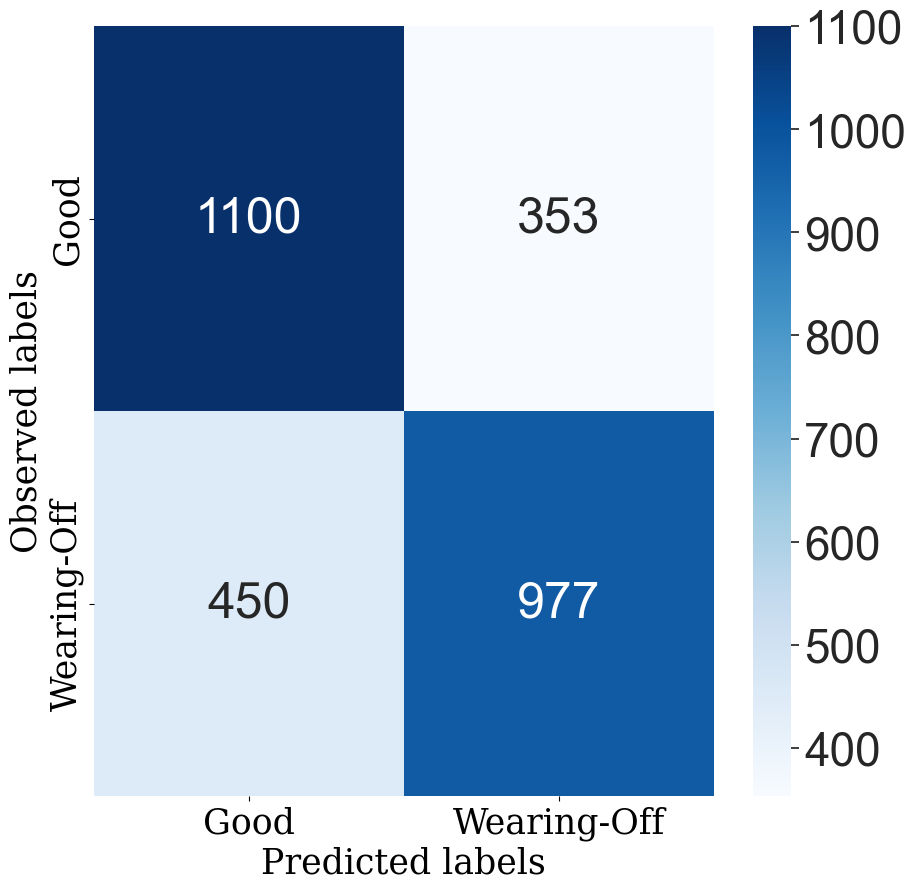


Computing permutation importances. This may take a while.
*****************************************************************************************************
Permutation Importances: Fitting model for outer fold 1
Permutation Importances: Calculating performances for outer fold 1


AttributeError: 'PhotonPipeline' object has no attribute 'classes_'

In [16]:
final_pipeline1 = Hyperpipe('5 - Final Pipeline CI GB',
                    outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                    inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                    use_test_set = True,
                    metrics = list(metrics.keys()),
                    best_config_metric='balanced_accuracy',
                    optimizer='sk_opt',
                    optimizer_params={'n_configurations': 30},
                    project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                    cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                    verbosity=1,
                    performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
final_pipeline1 += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

final_pipeline1 += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            })

# Fit hyperpipe
final_pipeline1.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(final_pipeline1.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(final_pipeline1)

# # View CV splits for debugging
# for k,v in final_pipeline1.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(final_pipeline1, with_estimator_comparison=False)

# Show confusion matrix
plot_confusion_matrix_from_pipeline(final_pipeline1)

# Show permutation feature importances
r = final_pipeline1.get_permutation_feature_importances(n_repeats=50, random_state=0, scoring='balanced_accuracy')

for i in r["mean"].argsort()[::-1]:
    # if r["mean"][i] - 2 * r["std"][i] >= 0:
        print(f"{np.array(columns[1:-1])[i]:<8}"
              f" {r['mean'][i]:.3f}"
              f" +/- {r['std'][i]:.3f}"
             )

In [ ]:
# Alternative 1: Built-in Feature Importances (Fastest)
print("Method 1: Built-in GradientBoosting Feature Importances")
print("-" * 55)
try:
    # Get the trained estimator
    gb_estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    
    if hasattr(gb_estimator, 'feature_importances_'):
        importances = gb_estimator.feature_importances_
        feature_names = np.array(columns[1:-1])
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        for i, idx in enumerate(indices):
            print(f"{feature_names[idx]:<20} {importances[idx]:.4f}")
    else:
        print("Built-in feature importances not available")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")


In [ ]:
# Alternative 2: Using sklearn's permutation_importance directly
print("Method 2: Sklearn Permutation Importance")
print("-" * 40)
try:
    from sklearn.inspection import permutation_importance
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a subset of data for faster computation (optional)
    # X_sample = X.sample(n=min(1000, len(X)), random_state=42)
    # y_sample = y.loc[X_sample.index]
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        fitted_pipeline, X, y, 
        n_repeats=10,  # Reduced for speed
        random_state=42,
        scoring='balanced_accuracy'
    )
    
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(perm_importance.importances_mean)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {perm_importance.importances_mean[idx]:.4f} "
              f"±{perm_importance.importances_std[idx]:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



In [ ]:
# Alternative 3: SHAP Values (if you have shap installed)
print("Method 3: SHAP Feature Importance")
print("-" * 35)
try:
    import shap
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a sample for SHAP (it can be slow on large datasets)
    X_sample = X.sample(n=min(500, len(X)), random_state=42)
    
    # Create explainer
    explainer = shap.Explainer(fitted_pipeline, X_sample)
    shap_values = explainer(X_sample)
    
    # Get mean absolute SHAP values as feature importance
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(feature_importance)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {feature_importance[idx]:.4f}")
        
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



In [ ]:
# Alternative 4: Simple DataFrame approach for better visualization
print("Method 4: DataFrame Summary")
print("-" * 25)
try:
    import pandas as pd
    
    # Using the original hyperpipe method but organizing results better
    r = final_pipeline1.get_permutation_feature_importances(
        n_repeats=20,  # Reduced for speed
        random_state=0, 
        scoring='balanced_accuracy'
    )
    
    # Create DataFrame for better organization
    importance_df = pd.DataFrame({
        'Feature': np.array(columns[1:-1]),
        'Importance': r["mean"],
        'Std_Dev': r["std"],
        'Lower_Bound': r["mean"] - 2 * r["std"],
        'Upper_Bound': r["mean"] + 2 * r["std"]
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Display top 10
    print("Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False, float_format='%.4f'))
    
    # Show only statistically significant features
    significant_features = importance_df[importance_df['Lower_Bound'] > 0]
    
    if len(significant_features) > 0:
        print(f"\nStatistically Significant Features ({len(significant_features)}):")
        print(significant_features.to_string(index=False, float_format='%.4f'))
    else:
        print("\nNo statistically significant features found")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



In [ ]:
# Alternative 5: Quick and Simple (Minimal Code)
print("Method 5: Quick and Simple")
print("-" * 25)
try:
    # Just get the built-in importances with minimal code
    estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    importances = estimator.feature_importances_
    features = np.array(columns[1:-1])
    
    # Create sorted list of (importance, feature) tuples
    sorted_features = sorted(zip(importances, features), reverse=True)
    
    print("Feature Importance Ranking:")
    for i, (importance, feature) in enumerate(sorted_features[:15], 1):
        print(f"{i:2d}. {feature:<20} {importance:.4f}")
        
except Exception as e:
    print(f"Error: {e}")